https://github.com/facebookresearch/detectron2/issues/2012

In [41]:
# Some basic setup:
# Setup detectron2 logger
import detectron2, torch
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt
# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# print("detectron2:", detectron2.__version__)

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("grass_weed_dataset_train", {}, "./data/train/annotations_coco.json", "./data/train/")
register_coco_instances("grass_weed_dataset_test",  {}, "./data/test/annotations_coco.json",  "./data/test/")


Train! Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the weed dataset


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # mask for segemntation but we don't do that here
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("grass_weed_dataset_train",)
cfg.DATASETS.TEST = ("grass_weed_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # don't know how many iteration requires ?
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # grassweed and ridderzuring

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

### Detect Sinlge Image

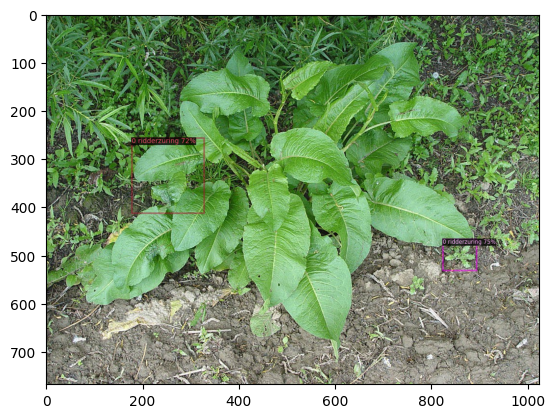

In [66]:
from detectron2.utils.visualizer import ColorMode
test_metadata = MetadataCatalog.get("grass_weed_dataset_train")
im = cv2.imread("a.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=1,
                instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

from PIL import Image
# Convert to RGB format (optional, but recommended for PIL)
image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.show()

#### Detects Multiple Images at once

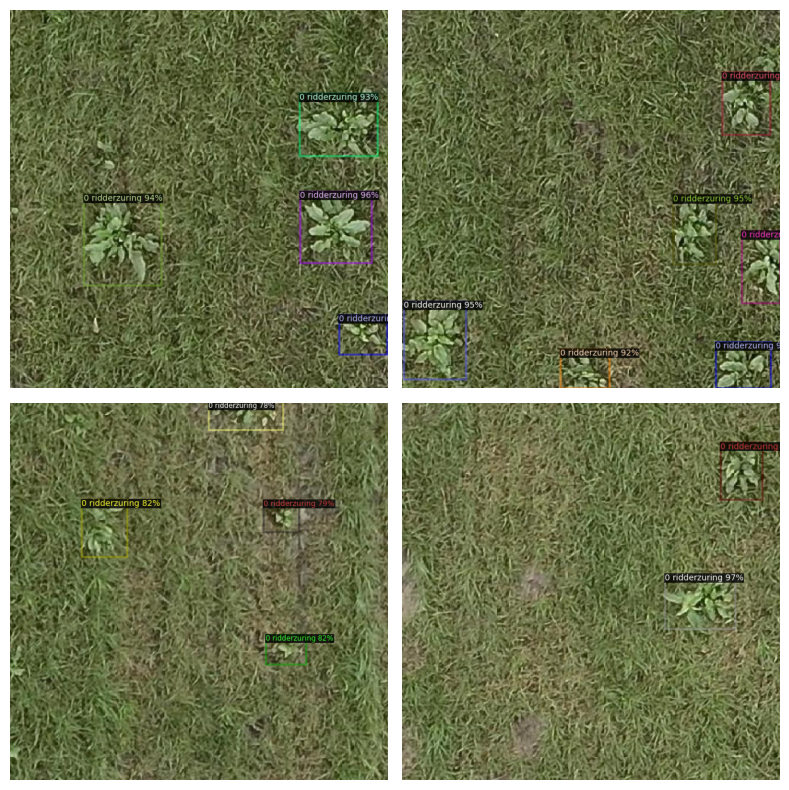

In [65]:
import glob
image_dir = "./data/test/"

# Number of images to process
num_images = 4 

# Get list of image files in the directory
image_files = glob.glob(os.path.join(image_dir, "*.jpg"))

# Randomly select 'num_images' images
selected_images = random.sample(image_files, num_images)

# Create a figure to display the grid
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, image_path in enumerate(selected_images):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    # Visualize the predictions
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=1, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # Convert to RGB format (optional, but recommended for PIL)
    image_pil = Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))    
    # Determine the position in the grid
    row = i // 2
    col = i % 2

    # Display the image
    axs[row, col].imshow(image_pil)
    axs[row, col].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output